In [ ]:
using Plots
using LaTeXStrings, ColorSchemes
using CSV, DataFrames
Plots.PyPlotBackend()

plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color=ColorSchemes.berlin[1])

function fluid_plot(sol, time_skip, save_every, x, s, tmax)
    dt = floor(Int64, time_skip / save_every)
    plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        title=L"Fluid profile at $\delta t = %$time_skip$ intervals", ylims=(0, Inf), xlims=(0, Lx))
    for i = 1:floor(Int64, tmax / time_skip)+1
        plot!(plt, x, sol.u[1+dt*(i-1)][2:end-1] + s)
    end
    plot!(plt, x, s, color="black")
    return plt
end

function fluid_anim(sol, ymax, xmax, x, s)
    anim = @animate for i = 1:size(sol.u)[1]
        timestep = sol.t[i]
        plot(x, sol.u[i][2:end-1] + s, legend=false, ylims=(0, ymax), xlims=(0, Lx), title=L"Fluid Profile $(t=%$timestep)$",
            xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
        plot!(x, s, color="black")
    end
    return anim
end

"""
Function to save fluid profile data to a CSV. CSV saved in the format of:
Timestamp | Ghost 1 | 0 | ... | Lx | Ghost 2
# Arguments
- `sol`: solution object of DiffEq solver
"""
function fluid_data(sol, path)
    CSV.write(path * "/data.csv", DataFrame(sol))
end

function save_params(path, filename="params")
    open(path * "/" * filename * ".txt", "w") do f
        domain_info = "# Domain Parameters\nnx: $nx\nLx: $Lx\ndx: $dx\n"
        topo_info = "\n# Topography Parameters\n$topo\n"
        init_cond_info = "\n# Initial Condition Parameters\n$ic_obj\n"
        ode_sys_info = "\n# ODE System Parameters\nD: $D\nC: $C\nalpha: $α\n"
        time_info = "\n# Time Parameters\ntime_span: $tspan\ntimestep_save: $save_every"
        write(f, domain_info * topo_info * init_cond_info * ode_sys_info * time_info)
    end
end

In [ ]:
"""
Custom struct for topogrpahy functions
"""
struct Topography
    f::Function
    params::Tuple
end

"""
Function describing a flat plane
"""
function flat(x)
    0
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `h`: optional arg for height scaling
"""
function bump(x, w, c, h=1)
    if x <= c - w || x >= c + w
        return 0
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2)))
    end
end

"""
Function describing a rectangular mound
# Arguments
- `x`: x coordinate
- `c`: x coordinate for left hand corner of mound
- `h`: height of mound
- `delta`: steepness of mound
- `w`: width of mound
"""
function mound(x, c, h, delta, w)
    h * (1 / pi * (atan((x - c) / delta) - atan((x - c - w) / delta)))
end

"""
Custom struct for initial condition functions
"""
struct InitialCondition
    f::Function
    params::Tuple
end

"""
Function describing a reflected sigmoid
# Arguments
- `x`: x coordinate
- `b`: precursor film height
- `xf`: center point of transition
- `c`: steepness of transition
- `h`: optional argument control initial height
"""
function reflected_sigmoid(x, b, xf, c, h=1)
    b + (h - b) / (1 + exp(1 / c * (x - xf)))
end

"""
Function describing a flat plane with respect to phi = 0
# Arguments
- `h`: film height relative to phi = 0
- `s`: topography
"""
function flat_profile(x, h, s, b=0.0)
    h - s + b
end

function front_tanh(x)
    0.45 * tanh(-5 * (x - 5)) + 0.55
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `b`: precursor film height
- `h`: optional arg for height scaling
"""
function ic_bump(x, w, c, b, h=1)
    if x <= c - w || x >= c + w
        return b
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2))) + b
    end
end

In [203]:
plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false)
# ================================
# Discretization of x-domain
# ================================
Lx = 100
dx = 0.05
nx = Lx / dx
x = 0.0:dx:Lx

# ================================
# Topography definition
# ================================
topo = Topography(flat, ())
s = topo.f.(x, topo.params...)

# ================================
# Initial Condition definition
# ================================
b = 0.1
c = 15
w = 1
h = ℯ*(1-b)
ic_obj = InitialCondition(ic_bump, (w, c, b, h))
ic = ic_obj.f.(x, ic_obj.params...)

# Adding ghost points
pushfirst!(ic, ic[1])
push!(ic, ic[end])

# ================================
# Parameters of the system of ODEs
# ================================

α = 0
g = 9.8 # m/s^2

# Oil Physical Properties
ρ = 900 # kg/m^3
γ = 20 * 10^(-3) # kg/s^2
μ = 0.045 # kg*m/s

# Saw Forcing Properties
A = 8 * 10^(-10) # m 
ω = 40 * pi * 10^6 # 1/s
α_1 = 2.386
k_i = -0.7683

# Scaling Factors
h_c = 200 * 10^(-6)
x_c = 10^(-3)
ϵ = h_c / x_c
t_c = (3 * μ * x_c^4) / (h_c^3 * γ)

# Dimless Params
Bo = (x_c^2 * ρ * g) / γ
We_ac = (ρ * ω^2 * A^2 * x_c) / γ

xsym = Symbol.(x)
pushfirst!(xsym, Symbol("ghost1"))
push!(xsym, Symbol("ghost2"))
print("End")

End

In [199]:
"""
Builds the system of ODEs (represented by du)
u = (h_-1, h_0, ..., h_nx, h_nx+1) where h_-1 and h_nx+1 are ghost points
"""
function system!(dh, h, p, t)
    α, dx, Bo, We_ac, ϵ, α_1, x_c, topo, params, b, λ, α_oil, α_air = p

    function phi(i)
        h[i] #+ topo(dx * (i-2), params...)
    end
    function interp(i)
        1/2 * (h[i]^3 + h[i+1]^3)
    end
    function f1(i)
        1/(dx^2) * (interp(i-1) * (phi(i-1) - phi(i)) + interp(i)*(phi(i+1) - phi(i)))
    end
    function f2(i)
        1 /(dx^4) * (interp(i-1) * (phi(i-2) - 3*phi(i-1) + 3*phi(i) - phi(i+1)) + interp(i) * (-phi(i-1) + 3*phi(i) - 3*phi(i+1) + phi(i+2)))
    end
    function f3(i)
        1/(2*dx) * (h[i+1]^3 - h[i-1]^3)
    end
    function f4(i, atten)

        function expo(j)
            x_j = dx * (j - 2)
            return exp(2 * atten * x_j)
        end

        (1/(2*dx)) * ((h[i+1]^3 * expo(i+1)) - (h[i-1]^3 * expo(i-1)))
        #(1/(2*dx)) * (expo(i)*(u[i+1]^3 + u[i]^3) - expo(i-1)*(u[i]^3 + u[i-1]^3))
    end
    function attenuation_coeff(h, b, λ, α_oil, α_air)
        h_bar = h - b   
        return (α_oil - α_air)*(1 - exp(-h_bar / λ)) + α_air
    end

    dh[1] = 0
    dh[2] = 0
    dh[end-1] = 0
    dh[end] = 0
    for i in 3:length(h)-2
        x_i = dx * (i - 2)
        #if x_i >= xl && x_i <= xr
        #    dh[i] = (Bo * cos(α))*f1(i) - f2(i) - (sin(α) * Bo * ϵ)*f3(i) + ((1+α_1^2)*ϵ*We_ac*k_i)*f4(i, xl)
        #else
        #    dh[i] = (Bo * cos(α))*f1(i) - f2(i) - (sin(α) * Bo * ϵ)*f3(i)
        #end
        atten = attenuation_coeff(h[i], b, λ, α_oil, α_air)
        atten = -abs(atten*x_c)
        C = ((1+α_1^2)*We_ac*atten)/ϵ
        dh[i] = (Bo * cos(α))*f1(i) - f2(i) - (sin(α) * Bo/ϵ)*f3(i) + C*f4(i, atten)
    end
    return dh
end

system!

In [198]:
using DifferentialEquations
using DiffEqCallbacks
using Interpolations, Roots

function inflection_point!(u, t, integrator)
    h = integrator(integrator.t, Val{0})[2:end-1]
    h1 = integrator(integrator.t, Val{1})[2:end-1]
    h2 = integrator(integrator.t, Val{2})[2:end-1]
    interp = LinearInterpolation(x, h2)
    x_min = dx * (findmin(h)[2] - 1)
    x0 = find_zero(interp, x_min)
    integrator.p[8] = x0
end

left_vals = zeros(0)
right_vals = zeros(0)

function inflection_point_new!(u, t, integrator)
    h = u[2:end-1]
    #h2 = integrator(integrator.t, Val{1})[2:end-1]

    #interp = LinearInterpolation(x, h2)

    x_max_idx = (findmax(h)[2])
    x_max = dx * (x_max_idx-1)

    x_min_left = dx * (findmin(h[1:x_max_idx])[2] - 1)
    x_min_right = dx * (findmin(h[x_max_idx+1:end])[2]) + x_max

    #integrator.p[8] = find_zero(interp, x_min_left) #x_min_left
    #integrator.p[9] = find_zero(interp, x_min_right)

    integrator.p[8] = x_min_left
    integrator.p[9] = x_min_right
    append!(left_vals, x_min_left)
    append!(right_vals, x_min_right)
end

func = 0
func_first = 0
func_sec = 0
function condition(u, t, integrator)
    t == 0.1
end
function affect(integrator)
    println("Affect!")
    global func = integrator(integrator.t, Val{0})[2:end-1]
    global func_first = integrator(integrator.t, Val{1})[2:end-1]
    global func_sec = integrator(integrator.t, Val{2})[2:end-1]
end
cb_1 = DiscreteCallback(condition, affect)

λ = 2 * 10^(-3)
p = [α, dx, Bo, We_ac, ϵ, α_1, x_c, topo.f, topo.params, b, λ/x_c, 1000, 1]
tspan = (0.0, 5*10^4)
save_every = 10^2
f = ODEFunction(system!, syms=xsym)
prob = ODEProblem(f, ic, tspan, p, saveat=save_every)
cb_2 = DiffEqCallbacks.FunctionCallingCallback(inflection_point_new!; func_everystep=true, func_start=false)
#sol = solve(prob, alg=Rodas4(), callback=cb_2, tstops=[0.1])
sol = solve(prob, alg=Rodas4())
#print("END")

retcode: Success
Interpolation: 1st order linear
t: 501-element Vector{Float64}:
     0.0
   100.0
   200.0
   300.0
   400.0
   500.0
   600.0
   700.0
   800.0
   900.0
     ⋮
 49200.0
 49300.0
 49400.0
 49500.0
 49600.0
 49700.0
 49800.0
 49900.0
 50000.0
u: 501-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
 [0.1, 0.1, 0.10000002491911988, 0.10000007161298102, 0.10000013714857812, 0.10000021879828731, 0.10000031403355476, 0.10000042051829913, 0.10000053610206545, 0.10000065881296576  …  0.10000056031854236, 0.10000045630989984, 0.10000035819009084, 0.10000026766792103, 0.10000018660783166, 0.10000011703501566, 0.10000006114016056, 0.10000002128376789, 0.1, 0.1]
 [0.1, 0.1, 0.10000003484199319, 0.10000010087325001, 0.10000019466198803, 0.10000031299035568, 0.1000004528471449, 0.10000061142026019, 0.10000078608897209, 0.10000097441598062  …  0.10000085055905142, 0.10000068764415873, 0.100000535

In [200]:
time_skip = 10^3
plt = fluid_plot(sol, time_skip, save_every, x, s, tspan[2])
anim = fluid_anim(sol, 0.5, Lx, x, s)
print("End")

End

In [ ]:
plot(x, sol.u[end][2:end-1], xlims=(0, Lx), ylims=(0, 1), grid=true)

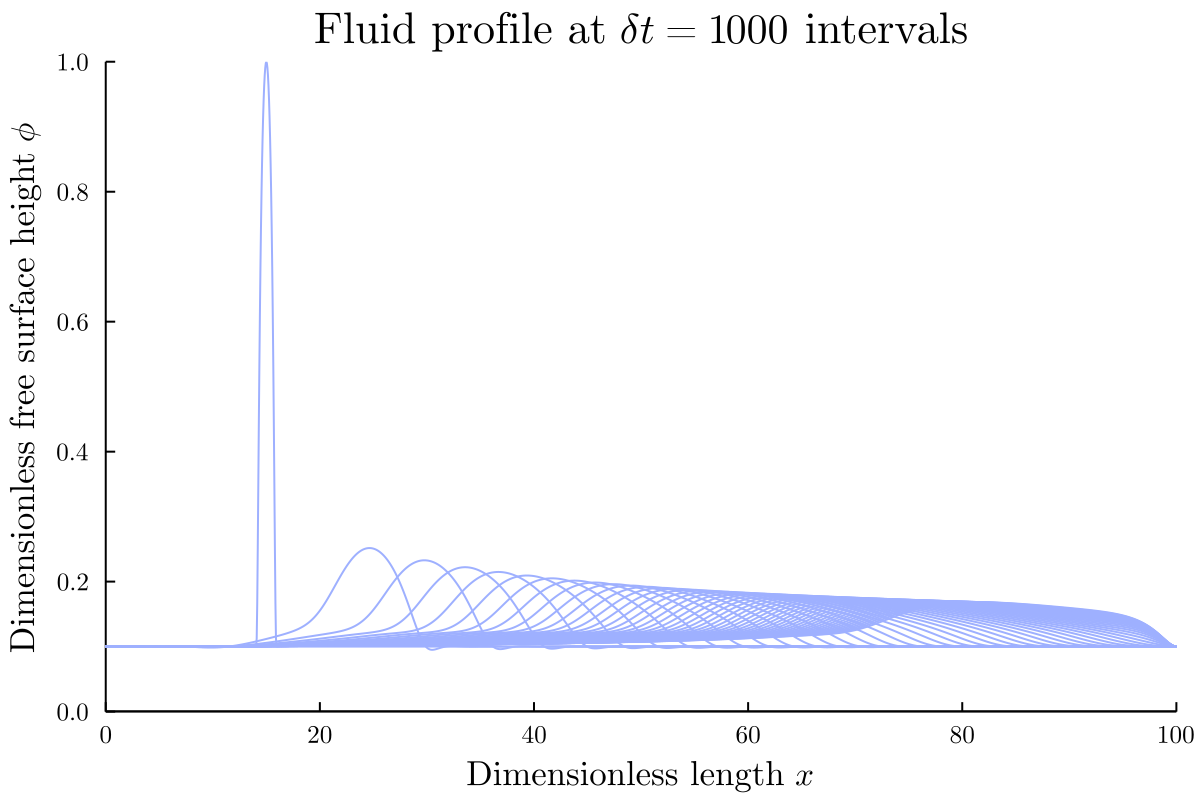

In [201]:
plt

┌ Info: Saved animation to 
│   fn = /var/folders/58/stll_lvs4sg8v_ry545yc1q80000gn/T/jl_8W8t7C.gif
└ @ Plots /Users/bsamineni/.julia/packages/Plots/cPJQu/src/animation.jl:114


Plots.AnimatedGif("/var/folders/58/stll_lvs4sg8v_ry545yc1q80000gn/T/jl_8W8t7C.gif")
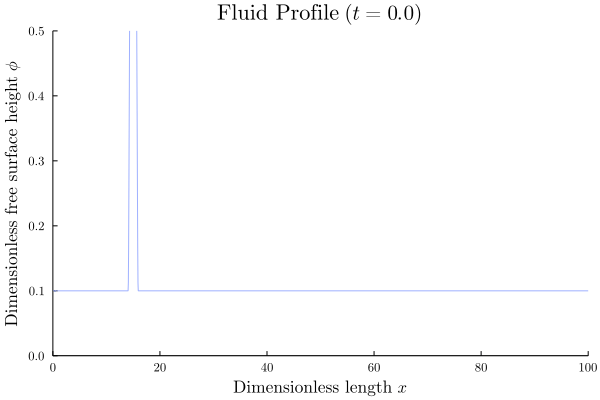

In [202]:
gif(anim, fps=30)